<a href="https://colab.research.google.com/github/Praveen-Web-Dev/Renewable-Dataset-Analysis/blob/main/Theme_1_2_2_3_Energy_Access_vs_Emission_Reduction(updated)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving cleaned_dataset.csv to cleaned_dataset.csv


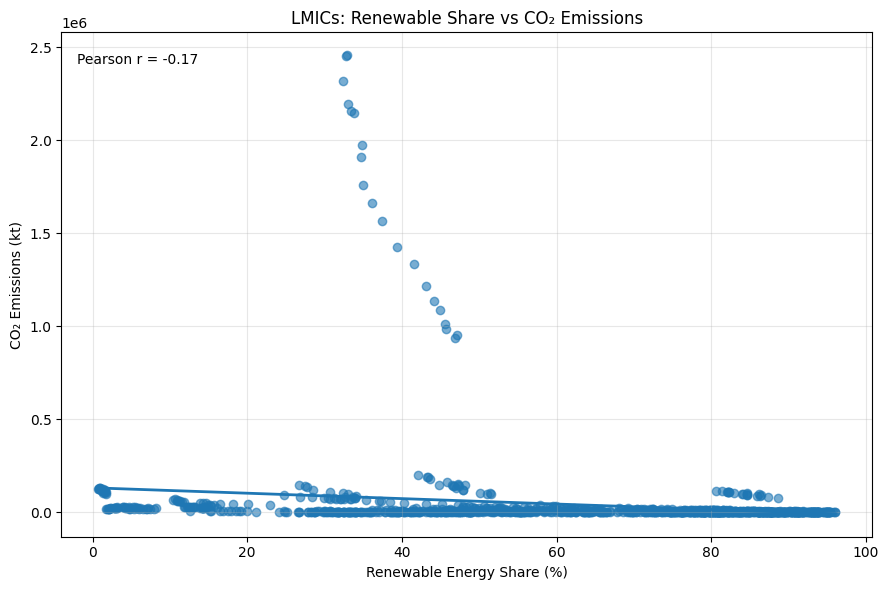

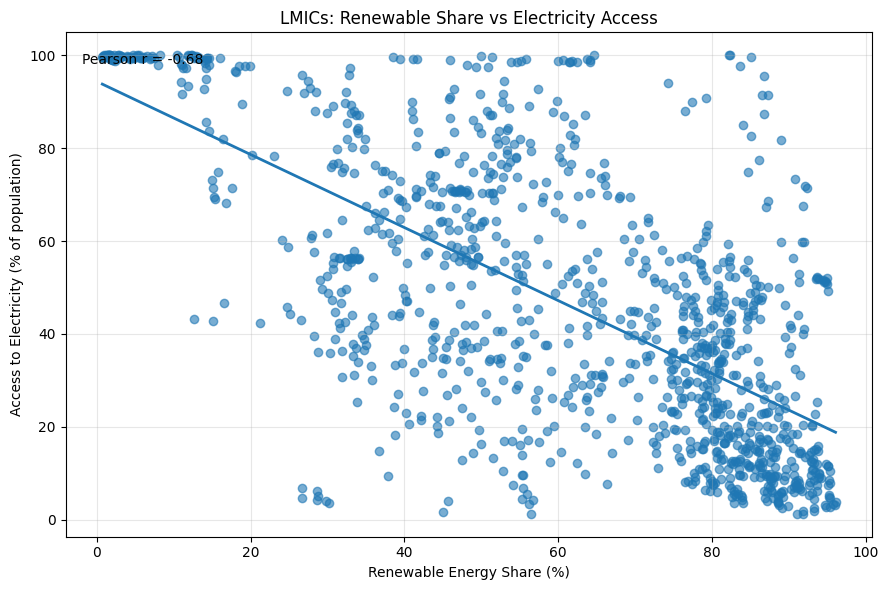

Summary (LMICs) — Mean Renewable Share & Electricity Access


,income,renewable_share,electricity_access
0,Low income,79.70,20.32
1,Lower middle income,52.05,58.91


In [1]:
# =========================
# One-cell analysis for 2.2.3
# =========================

# 0) Upload and load
from google.colab import files
uploaded = files.upload()

import io, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the first uploaded CSV
fname = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[fname]))

# 1) Rename columns for consistency (safe if already renamed)
df = df.rename(columns={
    'entity': 'country',
    'income_group': 'income',
    'value_co2_emissions_kt_by_country': 'co2_emissions',
    'renewable_energy_share_in_the_total_final_energy_consumption_(%)': 'renewable_share',
    'access_to_electricity_(%_of_population)': 'electricity_access',
    'gdp_per_capita': 'gdp_pc',
    'energy_intensity_level_of_primary_energy_(mj/$2017_ppp_gdp)': 'energy_intensity'
})

# 2) Filter LMICs
lmic_mask = df['income'].isin(['Low income', 'Lower middle income'])
df_lmic = df.loc[lmic_mask].copy()

# 3) Prepare LMIC datasets
cols_needed = ['income', 'year', 'renewable_share', 'co2_emissions', 'electricity_access']
missing_cols = [c for c in cols_needed if c not in df_lmic.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")

lmics_co2 = df_lmic[['renewable_share', 'co2_emissions']].dropna()
lmics_access = df_lmic[['income', 'year', 'renewable_share', 'electricity_access']].dropna()

# Safety checks
if lmics_co2.empty:
    raise ValueError("No LMIC rows with both 'renewable_share' and 'co2_emissions'.")
if lmics_access.empty:
    raise ValueError("No LMIC rows with both 'renewable_share' and 'electricity_access'.")

# 4) Helper: Pearson r and simple linear regression
def corr_and_line(x_arr, y_arr):
    x = np.asarray(x_arr)
    y = np.asarray(y_arr)
    x_mean, y_mean = x.mean(), y.mean()
    num = ((x - x_mean) * (y - y_mean)).sum()
    den = math.sqrt(((x - x_mean)**2).sum() * ((y - y_mean)**2).sum())
    r = num / den if den != 0 else np.nan
    a, b = np.polyfit(x, y, 1)  # y = a*x + b
    x_line = np.linspace(x.min(), x.max(), 200)
    y_line = a * x_line + b
    return r, x_line, y_line

# 5) Plot A: Renewable Share vs CO2 (LMICs)
r_co2, x_line_co2, y_line_co2 = corr_and_line(lmics_co2['renewable_share'], lmics_co2['co2_emissions'])

plt.figure(figsize=(9, 6))
plt.scatter(lmics_co2['renewable_share'], lmics_co2['co2_emissions'], alpha=0.6)
plt.plot(x_line_co2, y_line_co2, linewidth=2)
plt.title("LMICs: Renewable Share vs CO₂ Emissions")
plt.xlabel("Renewable Energy Share (%)")
plt.ylabel("CO₂ Emissions (kt)")
plt.grid(True, alpha=0.3)
plt.text(0.02, 0.96, f"Pearson r = {r_co2:.2f}", transform=plt.gca().transAxes, va='top')
plt.tight_layout()
plt.show()

# 6) Plot B: Renewable Share vs Electricity Access (LMICs)
r_acc, x_line_acc, y_line_acc = corr_and_line(lmics_access['renewable_share'], lmics_access['electricity_access'])

plt.figure(figsize=(9, 6))
plt.scatter(lmics_access['renewable_share'], lmics_access['electricity_access'], alpha=0.6)
plt.plot(x_line_acc, y_line_acc, linewidth=2)
plt.title("LMICs: Renewable Share vs Electricity Access")
plt.xlabel("Renewable Energy Share (%)")
plt.ylabel("Access to Electricity (% of population)")
plt.grid(True, alpha=0.3)
plt.text(0.02, 0.96, f"Pearson r = {r_acc:.2f}", transform=plt.gca().transAxes, va='top')
plt.tight_layout()
plt.show()

# 7) Summary table: means by LMIC income group (pooled 2000–2020)
summary_lmic = (
    lmics_access
    .groupby('income')[['renewable_share', 'electricity_access']]
    .mean()
    .round(2)
    .reset_index()
)

print("Summary (LMICs) — Mean Renewable Share & Electricity Access")
display(summary_lmic)

# Optional: save figures
# plt.figure(...); plt.savefig('lmic_renewables_vs_co2.png', dpi=150)
# plt.figure(...); plt.savefig('lmic_renewables_vs_access.png', dpi=150)
